<a href="https://colab.research.google.com/github/reiinakano/neural-painters/blob/master/notebooks/train_gan_painter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optionally connect to Google Drive

In [0]:
#from google.colab import drive
#drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /drive


## Install MyPaint and dependencies

In [0]:
# Install mypaint
!apt-get update
!apt-get install libjson-c-dev libgirepository1.0-dev libglib2.0-dev
!apt-get install autotools-dev intltool gettext libtool
!apt-get install swig python-setuptools gettext g++
!apt-get install -y libgtk-3-dev python-gi-dev
!apt-get install -y libpng-dev liblcms2-dev libjson-c-dev
!apt-get install -y gir1.2-gtk-3.0 python-gi-cairo
!apt-get install scons

!wget https://github.com/mypaint/libmypaint/releases/download/v1.3.0/libmypaint-1.3.0.tar.xz
!tar -xvf libmypaint-1.3.0.tar.xz
!mv libmypaint-1.3.0 libmypaint

!cd libmypaint && ./configure && make install

!wget https://github.com/mypaint/mypaint/releases/download/v1.2.1/mypaint-1.2.1.tar.xz
!tar -xvf mypaint-1.2.1.tar.xz
!mv mypaint-1.2.1 mypaint
!cd mypaint && scons && scons install

!ldconfig

!pip install ipdb tqdm pathlib cloudpickle  matplotlib

In [0]:
!pip install future-fstrings

In [0]:
!git clone https://github.com/reiinakano/SPIRAL-tensorflow.git
!cd SPIRAL-tensorflow && git checkout reiinakano-patch-2  #reiinakano-patches
!cd SPIRAL-tensorflow && git pull

Cloning into 'SPIRAL-tensorflow'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 154 (delta 3), reused 0 (delta 0), pack-reused 146
Receiving objects: 100% (154/154), 1.36 MiB | 1.51 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Branch 'reiinakano-patch-2' set up to track remote branch 'reiinakano-patch-2' from 'origin'.
Switched to a new branch 'reiinakano-patch-2'
Already up to date.


In [0]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

--2019-04-12 10:01:06--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.200.123.104, 34.204.22.7, 52.202.60.111, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.200.123.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977695 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.28M  7.00MB/s    in 2.0s    

2019-04-12 10:01:09 (7.00 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14977695/14977695]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


# Download episodes. 

If you want to use/generate your own brushstrokes, go to https://github.com/reiinakano/diff-painter/blob/master/notebooks/generate_stroke_examples.ipynb or put your data under the data/ folder.

Otherwise, you can download pre-calculated brushstrokes from Kaggle. You will need to set your API credentials via https://github.com/Kaggle/kaggle-api#api-credentials

In [0]:
!pip install kaggle

In [0]:
!mkdir -p ~/.kaggle

# Make sure to upload your Kaggle key from somewhere. I saved mine in Drive
#!cp "/drive/My Drive/kaggle.json" ~/.kaggle/

In [0]:
!kaggle datasets download reiinakano/mypaint_brushstrokes

100% 14.8G/14.8G [03:41<00:00, 86.8MB/s]
100% 14.8G/14.8G [03:41<00:00, 71.9MB/s]


In [0]:
!unzip mypaint_brushstrokes.zip

In [0]:
!mv strokes-dataset data

# import

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

import tensorflow as tf
import os

import sys
sys.path.append('mypaint')
sys.path.append('SPIRAL-tensorflow')

from lib import surface, tiledsurface, brush
from envs.mypaint_utils import *

import matplotlib.pyplot as plt

import tensorflow.contrib.layers as tcl

from IPython.display import display

import moviepy.editor as mpy
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

import time
print(tf.__version__)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1728512/45929032 bytes (3.8%)5554176/45929032 bytes (12.1%)9437184/45929032 bytes (20.5%)13336576/45929032 bytes (29.0%)17203200/45929032 bytes (37.5%)20881408/45929032 bytes (45.5%)24723456/45929032 bytes (53.8%)28540928/45929032 bytes (62.1%)32415744/45929032 bytes (70.6%)36306944/45929032 bytes (79.1%)40206336/45929032 bytes (87.5%)44072960/45929032 bytes (96.0%)

# paint environment

In [0]:
class args:
  jump=True
  curve=True
  screen_size=64
  location_size=32
  color_channel=3
  brush_path='SPIRAL-tensorflow/assets/brushes/dry_brush.myb'
  train=True
  data_dir=Path('data')

In [0]:
class PaintMode:
  STROKES_ONLY = 0
  JUMP_STROKES = 1
  CONNECTED_STROKES = 2

class ColorEnv():
    head = 0.25
    tail = 0.75
    
    # all 0 to 1
    actions_to_idx = {
        'pressure': 0,
        'size': 1,
        'control_x': 2,
        'control_y': 3,
        'end_x': 4,
        'end_y': 5,
        'color_r': 6,
        'color_g': 7,
        'color_b': 8,
        'start_x': 9,
        'start_y': 10,
        'entry_pressure': 11,
    }

    def __init__(self, args, paint_mode=PaintMode.JUMP_STROKES):
        self.args = args
        self.paint_mode = paint_mode

        # screen
        self.screen_size = args.screen_size
        self.height, self.width = self.screen_size, self.screen_size
        self.observation_shape = [
                self.height, self.width, args.color_channel]

        # location
        self.location_size = args.location_size
        self.location_shape = [self.location_size, self.location_size]
        
        self.prev_x, self.prev_y, self.prev_pressure = None, None, None
    
    @staticmethod
    def pretty_print_action(ac):
        for k, v in ColorEnv.actions_to_idx.items():
            print(k, ac[v])
    
    def random_action(self):
        return np.random.uniform(size=[len(self.actions_to_idx)])
      
    def reset(self):
        self.intermediate_images = []
        self.prev_x, self.prev_y, self.prev_pressure = None, None, None

        self.s = tiledsurface.Surface()
        self.s.flood_fill(0, 0, (255, 255, 255), (0, 0, 64, 64), 0, self.s)
        self.s.begin_atomic()

        with open(self.args.brush_path) as fp:
            self.bi = brush.BrushInfo(fp.read())
        self.b = brush.Brush(self.bi)

    def draw(self, ac, s=None, dtime=1):
        # Just added this
        if self.paint_mode == PaintMode.STROKES_ONLY:
          self.s.clear()
          self.s.flood_fill(0, 0, (255, 255, 255), (0, 0, 64, 64), 0, self.s)
          self.s.end_atomic()
          self.s.begin_atomic()
        
        if s is None:
            s = self.s

        s_x, s_y = ac[self.actions_to_idx['start_x']]*64, ac[self.actions_to_idx['start_y']]*64  
        e_x, e_y = ac[self.actions_to_idx['end_x']]*64, ac[self.actions_to_idx['end_y']]*64
        c_x, c_y = ac[self.actions_to_idx['control_x']]*64, ac[self.actions_to_idx['control_y']]*64
        color = (
            ac[self.actions_to_idx['color_r']],
            ac[self.actions_to_idx['color_g']],
            ac[self.actions_to_idx['color_b']],
        )
        pressure = ac[self.actions_to_idx['pressure']]*0.8
        entry_pressure = ac[self.actions_to_idx['entry_pressure']]*0.8
        size = ac[self.actions_to_idx['size']] * 2.
        
        if self.paint_mode == PaintMode.CONNECTED_STROKES:
            if self.prev_x is not None:
                s_x, s_y, entry_pressure = self.prev_x, self.prev_y, self.prev_pressure
            self.prev_x, self.prev_y, self.prev_pressure = e_x, e_y, pressure

        self.b.brushinfo.set_color_rgb(color)
        
        self.b.brushinfo.set_base_value('radius_logarithmic', size)

        # Move brush to starting point without leaving it on the canvas.
        self._stroke_to(s_x, s_y, 0)

        self._draw(s_x, s_y, e_x, e_y, c_x, c_y, entry_pressure, pressure, size, color, dtime)

    def _draw(self, s_x, s_y, e_x, e_y, c_x, c_y,
              entry_pressure, pressure, size, color, dtime):

        # if straight line or jump
        if pressure == 0:
            self.b.stroke_to(
                    self.s.backend, e_x, e_y, pressure, 0, 0, dtime)
        else:
            self.curve(c_x, c_y, s_x, s_y, e_x, e_y, entry_pressure, pressure)
            
        # Relieve brush pressure for next jump
        self._stroke_to(e_x, e_y, 0)

        self.s.end_atomic()
        self.s.begin_atomic()

    # sx, sy = starting point
    # ex, ey = end point
    # kx, ky = curve point from last line
    # lx, ly = last point from InteractionMode update
    def curve(self, cx, cy, sx, sy, ex, ey, entry_pressure, pressure):
        #entry_p, midpoint_p, junk, prange2, head, tail
        entry_p, midpoint_p, prange1, prange2, h, t = \
                self._line_settings(entry_pressure, pressure)

        points_in_curve = 100
        mx, my = midpoint(sx, sy, ex, ey)
        length, nx, ny = length_and_normal(mx, my, cx, cy)
        cx, cy = multiply_add(mx, my, nx, ny, length*2)
        x1, y1 = difference(sx, sy, cx, cy)
        x2, y2 = difference(cx, cy, ex, ey)
        head = points_in_curve * h
        head_range = int(head)+1
        tail = points_in_curve * t
        tail_range = int(tail)+1
        tail_length = points_in_curve - tail

        # Beginning
        px, py = point_on_curve_1(1, cx, cy, sx, sy, x1, y1, x2, y2)
        length, nx, ny = length_and_normal(sx, sy, px, py)
        bx, by = multiply_add(sx, sy, nx, ny, 0.25)
        self._stroke_to(bx, by, entry_p)
        pressure = abs(1/head * prange1 + entry_p)
        self._stroke_to(px, py, pressure)

        for i in xrange(2, head_range):
            px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
            pressure = abs(i/head * prange1 + entry_p)
            self._stroke_to(px, py, pressure)

        # Middle
        for i in xrange(head_range, tail_range):
            px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
            self._stroke_to(px, py, midpoint_p)

        # End
        for i in xrange(tail_range, points_in_curve+1):
            px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
            pressure = abs((i-tail)/tail_length * prange2 + midpoint_p)
            self._stroke_to(px, py, pressure)

        return pressure

    def _stroke_to(self, x, y, pressure, duration=0.1):
        self.b.stroke_to(
                self.s.backend,
                x, y,
                pressure,
                0.0, 0.0,
                duration)
        self.s.end_atomic()
        self.s.begin_atomic()
        self.intermediate_images.append(self.image)

    def save_image(self, path="test.png"):
        Image.fromarray(self.image.astype(np.uint8).squeeze()).save(path)
        #self.s.save_as_png(path, alpha=False)

    @property
    def image(self):
        rect = [0, 0, self.height, self.width]
        scanline_strips = \
                surface.scanline_strips_iter(self.s, rect)
        return next(scanline_strips)

    def _line_settings(self, entry_pressure, pressure):
        p1 = entry_pressure
        p2 = (entry_pressure + pressure) / 2
        p3 = pressure
        if self.head == 0.0001:
            p1 = p2
        prange1 = p2 - p1
        prange2 = p3 - p2
        return p1, p2, prange1, prange2, self.head, self.tail


# Sanity check data

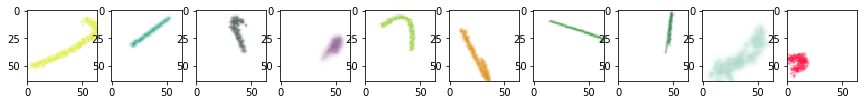

In [0]:
loaded = np.load('data/episodes_0.npz')

w=args.screen_size
h=args.screen_size
fig=plt.figure(figsize=(30, 10))
cols = 10

smaller_arr = loaded['strokes'][:cols]

for col in range(cols):
    img = smaller_arr[col][:, :, :3]
    #print(img.shape)
    fig.add_subplot(1, 20, col+1)
    plt.grid(False)
    plt.imshow(img)
plt.show()

In [0]:
for ac in loaded['actions'][:cols]:
  print('___')
  ColorEnv.pretty_print_action(ac)

# GAN Neural Painter

In [0]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(tf.minimum(0.0, alpha * x), x)

def leaky_relu_batch_norm(x, alpha=0.2):
    return leaky_relu(tf.contrib.layers.batch_norm(x, updates_collections=None), alpha)

def relu_batch_norm(x):
    return tf.nn.relu(tf.contrib.layers.batch_norm(x, updates_collections=None))
  
class DiscriminatorConditionalWM(object):
    def __init__(self, divisor=1):
        """
        make the network smaller by divisor times
        """
        self.x_dim = 64 * 64 * 3
        self.name = 'lsun/dcgan/d_net'
        self.divisor=divisor
        
    def __call__(self, x, conditions, reuse=True):
        with tf.variable_scope(self.name) as vs:
            if reuse:
                vs.reuse_variables()
            bs = tf.shape(x)[0]
            x = tf.reshape(x, [bs, 64, 64, 3])
            conditions = tf.reshape(conditions, [bs, 12])
            conditions = tf.contrib.layers.fully_connected(conditions, 64/self.divisor)
            conditions = tf.reshape(conditions, [bs, 1, 1, 64/self.divisor])
            conv1 = tcl.conv2d(
                x, 64/self.divisor, [4, 4], [2, 2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=leaky_relu
            )
            conv1 = conv1 + conditions
            conv2 = tcl.conv2d(
                conv1, 128/self.divisor, [4, 4], [2, 2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=leaky_relu_batch_norm
            )
            conv3 = tcl.conv2d(
                conv2, 256/self.divisor, [4, 4], [2, 2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=leaky_relu_batch_norm
            )
            conv4 = tcl.conv2d(
                conv3, 512/self.divisor, [4, 4], [2, 2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=leaky_relu_batch_norm
            )
            conv4 = tcl.flatten(conv4)
            fc = tcl.fully_connected(conv4, 1, activation_fn=tf.identity)
            return fc

    @property
    def vars(self):
        return [var for var in tf.global_variables() if self.name in var.name]

class GeneratorConditional(object):
    def __init__(self, divisor=1, add_noise=False):
        self.x_dim = 64 * 64 * 3
        self.divisor=divisor
        self.name = 'lsun/dcgan/g_net'
        self.add_noise = add_noise

    def __call__(self, conditions, is_training):
        with tf.contrib.framework.arg_scope([tcl.batch_norm], 
                                            is_training=is_training):
          with tf.variable_scope(self.name) as vs:
              bs = tf.shape(conditions)[0]
              if self.add_noise:
                conditions = tf.concat([conditions, tf.random.uniform([bs, 10])], axis=1)
              fc = tcl.fully_connected(conditions, 4 * 4 * 1024/self.divisor, activation_fn=tf.identity)
              conv1 = tf.reshape(fc, tf.stack([bs, 4, 4, 1024/self.divisor]))
              conv1 = relu_batch_norm(conv1)
              conv2 = tcl.conv2d_transpose(
                  conv1, 512/self.divisor, [4, 4], [2, 2],
                  weights_initializer=tf.random_normal_initializer(stddev=0.02),
                  activation_fn=relu_batch_norm
              )
              conv3 = tcl.conv2d_transpose(
                  conv2, 256/self.divisor, [4, 4], [2, 2],
                  weights_initializer=tf.random_normal_initializer(stddev=0.02),
                  activation_fn=relu_batch_norm
              )
              conv4 = tcl.conv2d_transpose(
                  conv3, 128/self.divisor, [4, 4], [2, 2],
                  weights_initializer=tf.random_normal_initializer(stddev=0.02),
                  activation_fn=relu_batch_norm
              )
              conv5 = tcl.conv2d_transpose(
                  conv4, 3, [4, 4], [2, 2],
                  weights_initializer=tf.random_normal_initializer(stddev=0.02),
                  activation_fn=tf.sigmoid)
              return conv5

    @property
    def vars(self):
        return [var for var in tf.global_variables() if self.name in var.name]

In [0]:
class ConvGAN(object):
  def __init__(self, learning_rate=0.0001, is_training=True, reuse=False, gpu_mode=True, data_glob='data/episodes_*.npz', divisor=1, add_noise=False, graph=None):
    self.learning_rate = learning_rate
    self.is_training = is_training
    self.reuse = reuse
    self.g_net = GeneratorConditional(divisor=divisor, add_noise=add_noise)
    self.d_net = DiscriminatorConditionalWM(divisor=divisor)
    
    if self.is_training:
      self.episode_files = tf.gfile.Glob(data_glob)
      np.random.shuffle(self.episode_files)
      self.ep_file_ctr = 0
      self.current_file_idx = 0
      loaded = np.load(self.episode_files[0])
      self.loaded_strokes = loaded['strokes']
      self.loaded_actions = loaded['actions']
      self.len_loaded = len(self.loaded_strokes)
    
    if not gpu_mode:
      with tf.device('/cpu:0'):
        tf.logging.info('conv_gan using cpu.')
        self._build_training_or_generator_graph(graph)
    else:
      tf.logging.info('conv_gan using gpu.')
      self._build_training_or_generator_graph(graph)
    self._init_session()
   
  def _build_training_or_generator_graph(self, graph):
    if self.is_training:
      self._build_graph(graph)
    else:
      self._build_generator_graph(graph)
  
  def _build_graph(self, graph):
    if graph is None:
      self.g = tf.Graph()
    else:
      self.g = graph
    with self.g.as_default(), tf.variable_scope('conv_gan', reuse=self.reuse):

      self.x = tf.placeholder(tf.float32, shape=[None, 64, 64, 3])
      self.actions = tf.placeholder(tf.float32, shape=[None, 12])
      
      self.y = self.g_net(self.actions, is_training=self.is_training)
      
      real_score = tf.reduce_mean(self.d_net(self.x, self.actions, reuse=False))
      generated_score = tf.reduce_mean(self.d_net(self.y, self.actions))
      
      real_score_summ = tf.summary.scalar('real_score', real_score)
      g_loss_summ = tf.summary.scalar('generated_score/g_loss', generated_score)
      
      reconstruction_loss = tf.reduce_mean(tf.square(self.y-self.x))
      recon_loss_summ = tf.summary.scalar('recon_loss', reconstruction_loss)
      
      # actual reconstruction loss used for training
      self.uneven_multiplier = tf.placeholder_with_default(1.0, [])
      u_m_summ = tf.summary.scalar('uneven_multiplier', self.uneven_multiplier)
      mask = tf.reduce_mean(
        self.x,
        reduction_indices = [3]
      )
      stroke_whitespace = tf.equal(mask, 1.0)
      mask = tf.where(stroke_whitespace, tf.ones(tf.shape(mask)), self.uneven_multiplier*tf.ones(tf.shape(mask)))
      mask = tf.reshape(mask, [-1, 64, 64, 1])
      mask = tf.tile(mask, [1, 1, 1, 3])
      tf.summary.image('mask', mask, max_outputs=3)
      print(mask.get_shape())
      self.r_loss = 10*tf.reduce_mean((tf.square(self.x - self.y))*mask)
      actual_recon_loss_summ = tf.summary.scalar('recon_loss_actual', self.r_loss)
      # /actual reconstruction loss used for training
      
      self.g_loss = generated_score + self.r_loss
      self.d_loss = real_score - generated_score
      
      epsilon = tf.random_uniform([], 0.0, 1.0)
      x_hat = epsilon * self.x + (1 - epsilon) * self.y
      d_hat = self.d_net(x_hat, self.actions)
      
      ddx = tf.gradients(d_hat, x_hat)[0]
      print(ddx.get_shape().as_list())

      ddx = tf.sqrt(tf.reduce_sum(tf.square(ddx), axis=(1, 2, 3)))
      ddx = tf.reduce_mean(tf.square(ddx - 1.0) * 10.0)
      
      self.d_loss = self.d_loss + ddx
      
      gradient_penalty_summ = tf.summary.scalar('gradient_penalty', ddx)
      d_loss_summ = tf.summary.scalar('actual_loss', self.d_loss)
      
      # train ops
      if self.is_training:
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        self.inc_global_step = tf.assign(self.global_step, self.global_step+1)

        self.d_adam, self.g_adam = None, None
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            self.d_adam = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9)\
                .minimize(self.d_loss, var_list=self.d_net.vars)
            self.g_adam = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9)\
                .minimize(self.g_loss, var_list=self.g_net.vars)

      # initialize vars
      self.init = tf.global_variables_initializer()
      
      #summary ops
      tf.summary.image('inp_img', self.x, max_outputs=3)
      tf.summary.image('output_img', self.y, max_outputs=3)
      self.summary_op = tf.summary.merge_all()
      
  def _build_generator_graph(self, graph):
    if graph is None:
      self.g = tf.Graph()
    else:
      self.g = graph
      
    with self.g.as_default(), tf.variable_scope('conv_gan', reuse=self.reuse):
      self.actions = tf.placeholder(tf.float32, shape=[None, 12])
      self.y = self.g_net(self.actions, is_training=self.is_training)
      self.init = tf.global_variables_initializer()
  
  def generate_stroke_graph(self, actions):
    with tf.variable_scope('conv_gan', reuse=True):
      with self.g.as_default():
        return self.g_net(actions, is_training=False)
      
  def get_random_batch(self, batch_size):
    while self.len_loaded - self.current_file_idx < batch_size:
      self.ep_file_ctr = (self.ep_file_ctr + 1) % len(self.episode_files)
      self.current_file_idx = 0
      print('loading new file', self.episode_files[self.ep_file_ctr])
      loaded = np.load(self.episode_files[self.ep_file_ctr])
      self.loaded_strokes = loaded['strokes']
      self.loaded_actions = loaded['actions']
      self.len_loaded = len(self.loaded_strokes)
      rand_idx = np.random.permutation(self.len_loaded)
      self.loaded_strokes = self.loaded_strokes[rand_idx]
      self.loaded_actions = self.loaded_actions[rand_idx]
    
    strokes = self.loaded_strokes[self.current_file_idx:self.current_file_idx+batch_size]
    strokes = strokes.astype(np.float)/255.0
    actions = self.loaded_actions[self.current_file_idx:self.current_file_idx+batch_size]
    
    self.current_file_idx += batch_size
    
    return strokes, actions
      
  def train(self, batch_size=64, num_batches=1000000):
    train_writer = tf.summary.FileWriter('logdir', self.g)
    start_time = time.time()
    uneven_multiplier = 10.
    for t in range(num_batches):
        d_iters = 5

        for _ in range(0, d_iters):
            strokes, actions = self.get_random_batch(batch_size)
            _, summ = self.sess.run((self.d_adam, self.summary_op), 
                                    feed_dict={self.x: strokes, self.actions: actions})

        strokes, actions = self.get_random_batch(batch_size)
        _, summ, _, step = self.sess.run((self.g_adam, self.summary_op, self.inc_global_step, self.global_step), 
                                      feed_dict={self.x: strokes, 
                                                 self.actions: actions, 
                                                 self.uneven_multiplier: uneven_multiplier})
        train_writer.add_summary(summ, step)
        
        if step > 295044:
          uneven_multiplier = 1.

        if step % 20 == 0:
            strokes, actions = self.get_random_batch(batch_size)
            d_loss = self.sess.run(
                self.d_loss, feed_dict={self.x: strokes, self.actions: actions}
            )
            g_loss = self.sess.run(
                self.g_loss, feed_dict={self.x: strokes, self.actions: actions}
            )
            print('Iter [%8d] Time [%5.4f] d_loss [%.4f] g_loss [%.4f]' %
                    (step, time.time() - start_time, d_loss, g_loss))
            
        if step % 2000 == 0:
            self.save_model()

  def _init_session(self):
    """Launch TensorFlow session and initialize variables"""
    self.sess = tf.Session(graph=self.g)
    self.sess.run(self.init)
  def close_sess(self):
    """ Close TensorFlow session """
    self.sess.close()
  def save_model(self, model_save_path='tf_gan3'):
    sess = self.sess
    step = sess.run(self.global_step)
    with self.g.as_default():
      saver = tf.train.Saver(tf.global_variables())
    checkpoint_path = os.path.join(model_save_path, 'gan')
    tf.logging.info('saving model %s.', checkpoint_path)
    saver.save(sess, checkpoint_path, step) # just keep one
  def load_checkpoint(self, checkpoint_path='tf_gan3', actual_path=None):
    sess = self.sess
    with self.g.as_default():
      saver = tf.train.Saver(tf.global_variables())
    ckpt = tf.train.get_checkpoint_state(checkpoint_path)
    if actual_path is None:
      actual_path = ckpt.model_checkpoint_path
    print('loading model', actual_path)
    tf.logging.info('Loading model %s.', actual_path)
    saver.restore(sess, actual_path)

# Training the GAN Neural painter

In [0]:
# Hyperparameters for ConvVAE
batch_size=100
learning_rate=0.0001

# Parameters for training
NUM_EPOCH = 10
DATA_DIR = "record"

model_save_path = "tf_gan3"
if not os.path.exists(model_save_path):
  os.makedirs(model_save_path)

In [0]:
def reset_graph():
  if 'sess' in globals() and sess:
    sess.close()
  tf.reset_default_graph()

reset_graph()

In [0]:
gan = ConvGAN(learning_rate=learning_rate,
              is_training=True,
              reuse=False,
              gpu_mode=True,
              divisor=4,
              add_noise=False)


INFO:tensorflow:conv_gan using gpu.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
(?, 64, 64, 3)
[None, 64, 64, 3]
Instructions for updating:
Use tf.cast instead.


## Running tensorboard

In [0]:
# Delete old logdir
#!rm -r logdir

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format('logdir')
)

get_ipython().system_raw('./ngrok http 6006 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


https://9943c449.ngrok.io


## Actual training

In [0]:
# Run this to start from a checkpoint
# gan.load_checkpoint('tf_gan3')


In [0]:
gan.train()

Iter [   45180] Time [16779.1555] d_loss [-0.3270] g_loss [21.1908]
('loading new file', 'data/episodes_21.npz')
Iter [   45200] Time [16792.5670] d_loss [-0.2331] g_loss [22.9276]
Iter [   45220] Time [16799.3478] d_loss [-0.4615] g_loss [20.1239]
Iter [   45240] Time [16806.1286] d_loss [-0.1133] g_loss [25.6514]
Iter [   45260] Time [16812.8861] d_loss [-0.4056] g_loss [22.6948]
Iter [   45280] Time [16819.6849] d_loss [-0.3526] g_loss [23.2790]
Iter [   45300] Time [16826.4535] d_loss [-0.7022] g_loss [24.4875]
Iter [   45320] Time [16833.2255] d_loss [-0.4282] g_loss [20.7543]
Iter [   45340] Time [16840.0225] d_loss [-0.2764] g_loss [21.9948]
Iter [   45360] Time [16846.7953] d_loss [0.0425] g_loss [17.6599]
Iter [   45380] Time [16853.5734] d_loss [-0.2378] g_loss [18.9157]
Iter [   45400] Time [16860.3679] d_loss [-0.3009] g_loss [24.2596]
Iter [   45420] Time [16867.1855] d_loss [-0.4271] g_loss [22.0943]
Iter [   45440] Time [16873.9668] d_loss [-0.1427] g_loss [20.5695]
('lo

KeyboardInterrupt: ignored

In [0]:
gan.save_model()

INFO:tensorflow:saving model tf_gan3/gan.


# Test your trained model

In [0]:
loaded = np.load('data/episodes_0.npz')
images = loaded['strokes']
images = np.reshape(images[-100:], [-1, 64, 64, 3])
actions = loaded['actions'][-100:]

In [0]:
test_gan = ConvGAN(learning_rate=learning_rate,
              is_training=False,
              reuse=False,
              gpu_mode=False,
              divisor=4,
              add_noise=False)


INFO:tensorflow:conv_gan using cpu.


In [0]:
def plot_images(images):
  h=args.screen_size
  fig=plt.figure(figsize=(16, 16))
  columns = len(images)
  rows = 1

  for i, img in enumerate(images):
    img = img[:, :, :3]
    #print(img.shape)
    fig.add_subplot(rows, columns, i+1)
    plt.grid(False)
    plt.imshow(img)
  plt.show()


('loading model', u'tf_gan3/gan-58443')
INFO:tensorflow:Loading model tf_gan3/gan-58443.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from tf_gan3/gan-58443


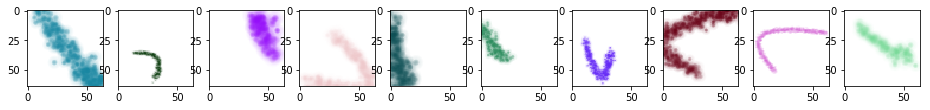

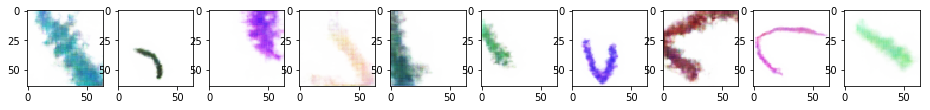

In [0]:

def experiment(to_plot, fn, actual=None):
  test_gan.load_checkpoint(fn, actual)
  images_to_plot = images[to_plot:to_plot+10].astype(np.float32)/255.
  plot_images(images_to_plot)
  decoded = test_gan.sess.run(test_gan.y, feed_dict={test_gan.actions: actions[to_plot:to_plot+10]})
  plot_images(decoded)
  plt.show()
  
experiment(10, 'tf_gan3')
#experiment(80, 'tf_vae', 'tf_vae/vae-189999')

In [0]:

def experiment5(test_models, duration=10.0):
  env = ColorEnv(args, paint_mode=PaintMode.STROKES_ONLY)
  env.reset()
  NUM_ACS = 8
  acs = [env.random_action() for _ in range(NUM_ACS)]
  
  def frame(t):
    t_ = t / duration
    t = np.abs((1.0-np.cos(NUM_ACS*np.pi*np.mod(t_, 1./NUM_ACS)))/2.0)
    
    new_ac = (1-t)*acs[int(np.floor(t_*NUM_ACS))] + t*acs[int((np.floor(t_*NUM_ACS)+1)%NUM_ACS)]
    env.draw(new_ac)
    im = env.image
    im = im[:, :, :3]
    stack_these = []
    for test_gan in test_models:
      decoded = test_gan.sess.run(test_gan.y, feed_dict={test_gan.actions: [new_ac]})[0]
      decoded = (decoded*255).astype(np.uint8)
      concatted = np.concatenate([im, decoded], 1)
      stack_these.append(concatted)
    return np.concatenate(stack_these, axis=0)
  
  clip = mpy.VideoClip(frame, duration=duration)
  clip.write_videofile('tmp.mp4', fps=30.0)
  display(mpy.ipython_display('tmp.mp4', height=400))

  
  
_test_gans = [ConvGAN(learning_rate=learning_rate,
              is_training=False,
              reuse=False,
              gpu_mode=False,
              divisor=4,
              add_noise=False) for x in range(1)]
_test_gans[0].load_checkpoint('tf_gan3')
#_test_gans[1].load_checkpoint('tf_gan3', 'tf_gan3/gan-400000')
#_test_gans[2].load_checkpoint('tf_gan3', 'tf_gan3/gan-300000')
experiment5(_test_gans, 20.)


INFO:tensorflow:conv_gan using cpu.
('loading model', u'tf_gan3/gan-58443')
INFO:tensorflow:Loading model tf_gan3/gan-58443.
INFO:tensorflow:Restoring parameters from tf_gan3/gan-58443
[MoviePy] >>>> Building video tmp.mp4
[MoviePy] Writing video tmp.mp4


100%|█████████▉| 600/601 [00:08<00:00, 73.24it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: tmp.mp4 

